#### Introduction
This is a machine learning project to predict unit/property monthly rent price in Kuala Lumpur region, Malaysia. The project uses a dataset from an online ads listing for property mudah.my. This project outlines the process of web-scraping/ data gathering, data cleaning-wrangling, and machine learning modeling.

This project aims to answers question about how much a unit monthly rent would be if given information such as location, number of bedrooms, parking, furnished, etc? This would help potential tenant and also the owner to get the best price of their rental unit, comparable to the market value.

Some previous work about house pricing was listed below, however most of them are targeting a dataset of house pricing or an Airbnb pricing. There are difference such as in Airbnb, the booking rarely took more than 2 weeks, let alone a year. Therefore the pricing may be different. Additionally, in Airbnb, there is text feature coming from the review given by the tenant and the owner.The better the review, the higher the rent prices -- which was not available in this current project dataset.

Previous work by [@madhuri2019], [@xu2022], [@zhao2022] highlight the importance feature selection, and the choice of machine learning model. Based on the previous works, the most consistently performed machine learning model are Random Forest and Gradient boosting, and the MAE and R2 score usually used in evaluating the performance of the model. Although the above work are all not about apartment rent pricing, similar method can be applied to this project.

The following feature is available in the dataset:

ads_id: ads listing ID, unique to each ads
prop_name: the building name of the property
completion_year: year of the building/property completed
monthly_rent: monthly rent price in Malaysian Ringgit (RM)
location: the location (region) of the property
property_type: property type, such as flat, apartment, etc
rooms: number of rooms
parking: number of parking spot
bathroom: number of bathroom
size: total area of the unit in sq.ft
furnished: furnishin status of the unit, fully-partial-non
facilities: main facilities within the unit
additional_facilities: additional facilities

In [1]:
import polars as pl
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Data Understanding
Reload the original dataset.

In [2]:
file_path = "./mudah-apartment-kl-selangor.csv"

In [3]:
df = pl.read_csv(file_path, infer_schema_length=10000) 

In [4]:
df

ads_id,prop_name,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,facilities,additional_facilities,region
i64,str,f64,str,str,str,str,f64,f64,str,str,str,str,str
100323185,"""The Hipster @ …",2022.0,"""RM 4 200 per m…","""Kuala Lumpur -…","""Condominium""","""5""",2.0,6.0,"""1842 sq.ft.""","""Fully Furnishe…","""Minimart, Gymn…","""Air-Cond, Cook…","""Kuala Lumpur"""
100203973,"""Segar Courts""",null,"""RM 2 300 per m…","""Kuala Lumpur -…","""Condominium""","""3""",1.0,2.0,"""1170 sq.ft.""","""Partially Furn…","""Playground, Pa…","""Air-Cond, Cook…","""Kuala Lumpur"""
100323128,"""Pangsapuri Ter…",null,"""RM 1 000 per m…","""Kuala Lumpur -…","""Apartment""","""3""",null,2.0,"""650 sq.ft.""","""Fully Furnishe…","""Minimart, Jogg…",null,"""Kuala Lumpur"""
100191767,"""Sentul Point S…",2020.0,"""RM 1 700 per m…","""Kuala Lumpur -…","""Apartment""","""2""",1.0,2.0,"""743 sq.ft.""","""Partially Furn…","""Parking, Playg…","""Cooking Allowe…","""Kuala Lumpur"""
97022692,"""Arte Mont Kiar…",null,"""RM 1 299 per m…","""Kuala Lumpur -…","""Service Reside…","""1""",1.0,1.0,"""494 sq.ft.""","""Not Furnished""","""Parking, Secur…","""Air-Cond""","""Kuala Lumpur"""
100322897,"""Residensi Vist…",null,"""RM 1 500 per m…","""Kuala Lumpur -…","""Apartment""","""3""",1.0,2.0,"""884 sq.ft.""","""Partially Furn…","""Parking, Secur…","""Cooking Allowe…","""Kuala Lumpur"""
100322962,"""Sky Meridien""",null,"""RM 2 900 per m…","""Kuala Lumpur -…","""Service Reside…","""3""",2.0,2.0,"""982 sq.ft.""","""Fully Furnishe…","""Parking, Secur…","""Air-Cond, Cook…","""Kuala Lumpur"""
100322885,"""Arte Plus Jala…",2018.0,"""RM 1 550 per m…","""Kuala Lumpur -…","""Service Reside…","""1""",1.0,1.0,"""700 sq.ft.""","""Fully Furnishe…","""Parking, Gymna…","""Air-Cond, Cook…","""Kuala Lumpur"""
100322866,"""Nova I""",2014.0,"""RM 1 400 per m…","""Kuala Lumpur -…","""Apartment""","""2""",1.0,1.0,"""750 sq.ft.""","""Fully Furnishe…","""Playground, Se…","""Air-Cond, Cook…","""Kuala Lumpur"""


##### Data Description

In [5]:
df.describe()

describe,ads_id,prop_name,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,facilities,additional_facilities,region
str,f64,str,f64,str,str,str,str,f64,f64,str,str,str,str,str
"""count""",19991.0,"""19991""",19991.0,"""19991""","""19991""","""19991""","""19991""",19991.0,19991.0,"""19991""","""19991""","""19991""","""19991""","""19991"""
"""null_count""",0.0,"""948""",9185.0,"""2""","""0""","""0""","""6""",5702.0,6.0,"""0""","""5""","""2209""","""5948""","""0"""
"""mean""",9.9707e7,null,2014.822321,null,null,null,null,1.416824,1.891719,null,null,null,null,null
"""std""",3.4826e6,null,6.735355,null,null,null,null,0.567368,0.556266,null,null,null,null,null
"""min""",1.6525511e7,"""1 Harmonis""",1977.0,"""RM 1 000 per m…","""Kuala Lumpur -…","""Apartment""","""1""",1.0,1.0,"""1 sq.ft.""","""Fully Furnishe…","""Barbeque area""",""", Air-Cond, Co…","""Kuala Lumpur"""
"""max""",1.00854617e8,"""wangsa maju se…",2025.0,"""RM 999 per mon…","""Selangor - Ulu…","""Townhouse Cond…","""More than 10""",10.0,8.0,"""99999999 sq.ft…","""Partially Furn…","""Tennis Court, …","""Washing Machin…","""Selangor"""
"""median""",1.00212678e8,null,2017.0,null,null,null,null,1.0,2.0,null,null,null,null,null


##### Only select house in Kuala Lumpur Region

##### Drop Duplicate

In [6]:
df.filter(df.is_duplicated())

ads_id,prop_name,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,facilities,additional_facilities,region
i64,str,f64,str,str,str,str,f64,f64,str,str,str,str,str
100828884,"""Saville @ Cher…",2019.0,"""RM 1 800 per m…","""Selangor - Che…","""Service Reside…","""2.0""",1.0,1.0,"""1367 sq.ft.""","""Fully Furnishe…","""Gymnasium, Squ…","""Air-Cond, Cook…","""Selangor"""
100828884,"""Saville @ Cher…",2019.0,"""RM 1 800 per m…","""Selangor - Che…","""Service Reside…","""2.0""",1.0,1.0,"""1367 sq.ft.""","""Fully Furnishe…","""Gymnasium, Squ…","""Air-Cond, Cook…","""Selangor"""
100822848,"""Taming Mutiara…",null,"""RM 1 200 per m…","""Selangor - Ban…","""Apartment""","""3.0""",2.0,2.0,"""986 sq.ft.""","""Fully Furnishe…","""Parking, Secur…","""Cooking Allowe…","""Selangor"""
100822848,"""Taming Mutiara…",null,"""RM 1 200 per m…","""Selangor - Ban…","""Apartment""","""3.0""",2.0,2.0,"""986 sq.ft.""","""Fully Furnishe…","""Parking, Secur…","""Cooking Allowe…","""Selangor"""
100800319,"""Greenfield Res…",2021.0,"""RM 1 500 per m…","""Selangor - Ban…","""Service Reside…","""2.0""",1.0,1.0,"""581 sq.ft.""","""Partially Furn…","""Jogging Track,…","""Air-Cond, Cook…","""Selangor"""
100800319,"""Greenfield Res…",2021.0,"""RM 1 500 per m…","""Selangor - Ban…","""Service Reside…","""2.0""",1.0,1.0,"""581 sq.ft.""","""Partially Furn…","""Jogging Track,…","""Air-Cond, Cook…","""Selangor"""
100786964,"""Desa Saujana""",null,"""RM 900 per mon…","""Selangor - Ser…","""Apartment""","""3.0""",1.0,2.0,"""850 sq.ft.""","""Fully Furnishe…","""Parking, Gymna…","""Cooking Allowe…","""Selangor"""
100786964,"""Desa Saujana""",null,"""RM 900 per mon…","""Selangor - Ser…","""Apartment""","""3.0""",1.0,2.0,"""850 sq.ft.""","""Fully Furnishe…","""Parking, Gymna…","""Cooking Allowe…","""Selangor"""
100691270,"""Sri Sunway Apa…",2002.0,"""RM 950 per mon…","""Selangor - Puc…","""Apartment""","""3.0""",1.0,2.0,"""823 sq.ft.""","""Partially Furn…","""Security, Play…","""Air-Cond, Cook…","""Selangor"""


In [7]:
df = df.unique()

##### Extracting Number and Keyword

In [8]:
df = df.with_columns(pl.col("monthly_rent").apply(lambda x: int(re.search(r'RM (.*?) per', x).group(1).replace(' ', ''))))
df = df.rename({"monthly_rent": "monthly_rent_rm"})

In [9]:
df = df.with_columns(pl.col("size").apply(lambda x: int(re.search(r'(.*?) sq', x).group(1).replace(' ', ''))))
df = df.rename({'size': 'size_sqft'})

In [10]:
df = df.with_columns(pl.col("location").apply(lambda x: re.sub(r"Kuala Lumpur - \s*", "", x)))

In [11]:
df = df.with_columns(pl.col("location").apply(lambda x: re.sub(r"Selangor - \s*", "", x)))

In [12]:
df

ads_id,prop_name,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,additional_facilities,region
i64,str,f64,i64,str,str,str,f64,f64,i64,str,str,str,str
100774711,"""Riana Green""",2003.0,1300,"""Petaling Jaya""","""Condominium""","""2.0""",1.0,1.0,745,"""Partially Furn…","""Swimming Pool,…","""Air-Cond, Cook…","""Selangor"""
100829586,"""D'Cerrum Apart…",2019.0,700,"""Semenyih""","""Apartment""","""3.0""",2.0,2.0,950,"""Partially Furn…",null,null,"""Selangor"""
100753384,"""Seri Jati Apar…",null,1000,"""Shah Alam""","""Apartment""","""3.0""",2.0,2.0,813,"""Not Furnished""",null,null,"""Selangor"""
100298746,"""OUG Parklane""",null,1200,"""OUG""","""Service Reside…","""3""",1.0,2.0,950,"""Partially Furn…","""Squash Court, …",null,"""Kuala Lumpur"""
99604313,"""Ascenda Reside…",2017.0,1400,"""Setapak""","""Condominium""","""3""",2.0,2.0,908,"""Partially Furn…","""Security, Swim…","""Cooking Allowe…","""Kuala Lumpur"""
100778798,"""Lakefront Home…",2021.0,1500,"""Cyberjaya""","""Condominium""","""3.0""",2.0,2.0,1010,"""Not Furnished""","""Parking, Secur…","""Cooking Allowe…","""Selangor"""
100673552,"""Desaminium Rim…",2005.0,1200,"""Seri Kembangan…","""Condominium""","""5.0""",1.0,3.0,1050,"""Partially Furn…","""Parking, Joggi…",null,"""Selangor"""
100090822,"""The Plaza Cond…",2007.0,4300,"""Taman Tun Dr I…","""Condominium""","""4""",2.0,3.0,1826,"""Fully Furnishe…","""Parking, Playg…","""Air-Cond, Cook…","""Kuala Lumpur"""
85185184,"""Taman Miharja …",null,1500,"""Cheras""","""Apartment""","""3""",1.0,2.0,950,"""Partially Furn…","""Parking""","""Air-Cond, Cook…","""Kuala Lumpur"""


##### Extracting Near KTM/LRT
Hypotheses: closer access to KTM/LRT = higher monthly rent

In [13]:
# Extracting "near KTM/LRT" into its own column.
def extract_near_ktm_lrt(text):
    pattern = re.compile(r'\bNear KTM/LRT\b')
    try:
        match = pattern.search(text)
        if match:
            return True
        return False
    except TypeError:
        return text

In [14]:
df["additional_facilities"].apply(lambda x: extract_near_ktm_lrt(x))

additional_facilities
bool
false
null
null
null
false
false
null
true
true


In [15]:
df = df.select([
    pl.all(),
    pl.col("additional_facilities").apply(lambda x: extract_near_ktm_lrt(x)).alias("nearby_railways")
])

In [16]:
near_ktmlrt = df.filter(pl.col("nearby_railways") == True).select(pl.col("monthly_rent_rm")).median().item()
not_near_ktmlrt = df.filter(pl.col("nearby_railways") == False).select(pl.col("monthly_rent_rm")).median().item()

In [17]:
f"""
Median:
Nearby KTM/LRT: {near_ktmlrt:.0f} RM
Not nearby KTM/LRT: {not_near_ktmlrt:.0f} RM
"""

'\nMedian:\nNearby KTM/LRT: 1500 RM\nNot nearby KTM/LRT: 1400 RM\n'

#### 
Plotting the difference between nearby KTM/LRT or not:

(0.0, 4000.0)

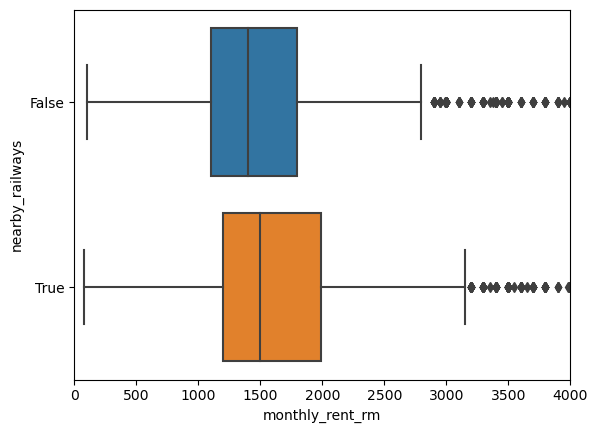

In [18]:
#| label: fig-nearbyktm
#| fig-cap: Boxplot between Nearby KTM/LRT or Not

sns.boxplot(data=df.to_pandas(), x='monthly_rent_rm', y='nearby_railways')
plt.xlim(0,4000)

In [19]:
df

ads_id,prop_name,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,additional_facilities,region,nearby_railways
i64,str,f64,i64,str,str,str,f64,f64,i64,str,str,str,str,bool
100774711,"""Riana Green""",2003.0,1300,"""Petaling Jaya""","""Condominium""","""2.0""",1.0,1.0,745,"""Partially Furn…","""Swimming Pool,…","""Air-Cond, Cook…","""Selangor""",false
100829586,"""D'Cerrum Apart…",2019.0,700,"""Semenyih""","""Apartment""","""3.0""",2.0,2.0,950,"""Partially Furn…",null,null,"""Selangor""",null
100753384,"""Seri Jati Apar…",null,1000,"""Shah Alam""","""Apartment""","""3.0""",2.0,2.0,813,"""Not Furnished""",null,null,"""Selangor""",null
100298746,"""OUG Parklane""",null,1200,"""OUG""","""Service Reside…","""3""",1.0,2.0,950,"""Partially Furn…","""Squash Court, …",null,"""Kuala Lumpur""",null
99604313,"""Ascenda Reside…",2017.0,1400,"""Setapak""","""Condominium""","""3""",2.0,2.0,908,"""Partially Furn…","""Security, Swim…","""Cooking Allowe…","""Kuala Lumpur""",false
100778798,"""Lakefront Home…",2021.0,1500,"""Cyberjaya""","""Condominium""","""3.0""",2.0,2.0,1010,"""Not Furnished""","""Parking, Secur…","""Cooking Allowe…","""Selangor""",false
100673552,"""Desaminium Rim…",2005.0,1200,"""Seri Kembangan…","""Condominium""","""5.0""",1.0,3.0,1050,"""Partially Furn…","""Parking, Joggi…",null,"""Selangor""",null
100090822,"""The Plaza Cond…",2007.0,4300,"""Taman Tun Dr I…","""Condominium""","""4""",2.0,3.0,1826,"""Fully Furnishe…","""Parking, Playg…","""Air-Cond, Cook…","""Kuala Lumpur""",true
85185184,"""Taman Miharja …",null,1500,"""Cheras""","""Apartment""","""3""",1.0,2.0,950,"""Partially Furn…","""Parking""","""Air-Cond, Cook…","""Kuala Lumpur""",true


In [20]:
df.filter(pl.col('prop_name') == 'Majestic Maxim')["nearby_railways"].value_counts()

nearby_railways,counts
bool,u32
null,32
true,166
false,24


####
As seen above, @fig-nearbyktm shows that it sligthly increases the median monthly rent by 50RM. However, near KTM/LRT is not appearing in all row even though the property is the same

Conclusion: Near KTM/LRT may be used, but it can be improved as the listing is inconsistent

##### Drop Missing Values in Facilities and Additional Facilities

In [21]:
df.select(pl.all().is_null()).sum()

ads_id,prop_name,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,additional_facilities,region,nearby_railways
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,948,9181,2,0,0,6,5699,6,0,5,2208,5945,0,5945


In [22]:
# #dropping some columns
df = df.drop(['ads_id', 
    'prop_name', 
    'facilities', 
    'additional_facilities'])

In [23]:
df.select(pl.col("rooms")).unique()

rooms
str
"""5.0"""
"""7"""
"""2"""
"""1.0"""
"""2.0"""
"""7.0"""
"""4.0"""
null
"""5"""


####
Converting rooms from object to int64

In [24]:
df = df.with_columns(pl.col("rooms").apply(lambda x: 10 if x == "More than 10" else x))

In [25]:
df = df.with_columns(pl.col("rooms").cast(pl.Float64))

In [26]:
df = df.with_columns(pl.col("rooms").cast(pl.Int64))

##### Outlier Removal
To remove some unexplainable data such as 0 monthly rent, 0 size, the rent that is way too old (1970), including the monthly rent that is way too high and/or size too big.

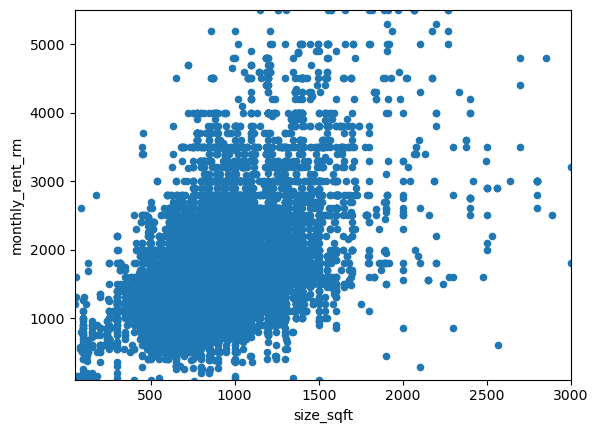

In [27]:
#| label: fig-size-rent
#| fig-cap: "Monthly Rent"
df.to_pandas()[['size_sqft', 'monthly_rent_rm']].plot(kind='scatter', x='size_sqft', y='monthly_rent_rm');
plt.ylim(100,5500)
plt.xlim(50,3000)
plt.show()

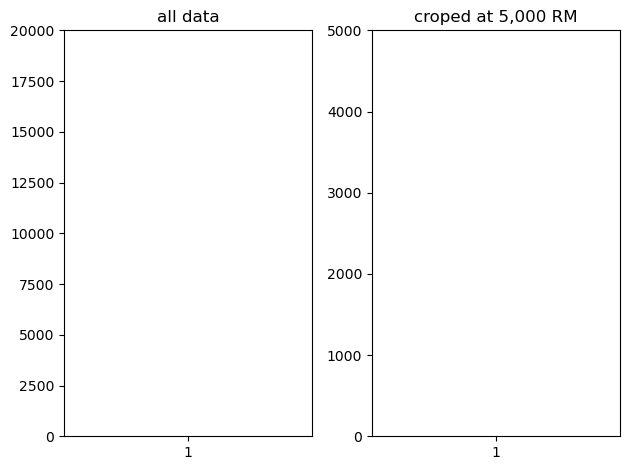

In [28]:
#| label: fig-compare-rent
#| fig-cap: "Comparison between Different Scale"
fig, axs = plt.subplots(1,2)
axs[0].boxplot(data=df.to_pandas(), x='monthly_rent_rm')
axs[0].set_ylim(0,20000)
axs[0].set_title('all data')

axs[1].boxplot(data=df.to_pandas(), x='monthly_rent_rm')
axs[1].set_ylim(0,5000)
axs[1].set_title('croped at 5,000 RM')

plt.tight_layout()
plt.show()

<Axes: title={'center': 'all data'}>

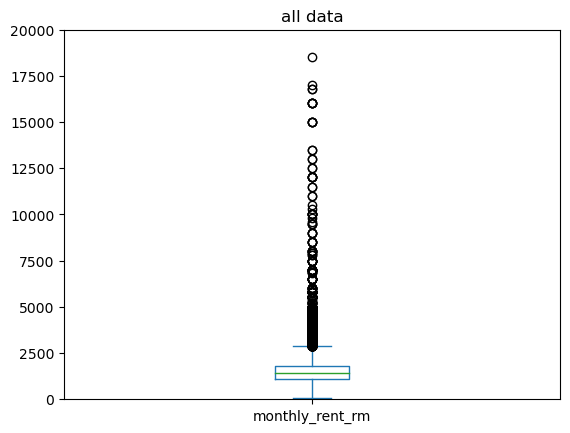

In [29]:
df.to_pandas()["monthly_rent_rm"].plot(kind="box", ylim = (0,20000), title='all data')

<Axes: title={'center': 'croped at 5,000 RM'}>

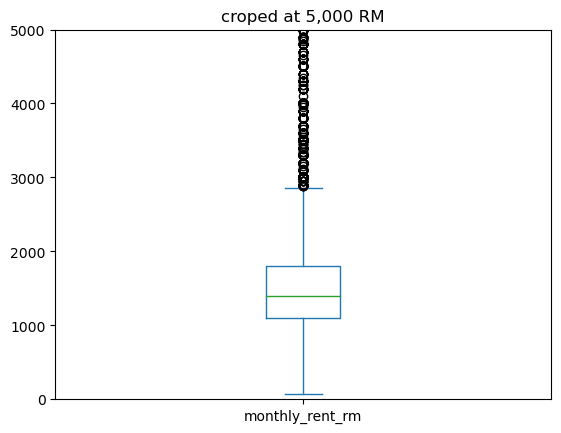

In [30]:
df.to_pandas()["monthly_rent_rm"].plot(kind="box", ylim = (0,5000), title='croped at 5,000 RM')

#### 
Based on EDA on @fig-size-rent and @fig-compare-rent, author decided to filter the data between 100-5500 RM as follows:

In [31]:
df.columns

['completion_year',
 'monthly_rent_rm',
 'location',
 'property_type',
 'rooms',
 'parking',
 'bathroom',
 'size_sqft',
 'furnished',
 'region',
 'nearby_railways']

In [32]:
# removing all rows with monthly rent above 5500 RM and below 100RM
dfx = df.filter((pl.col("monthly_rent_rm") > 100) & (pl.col("monthly_rent_rm") < 5500))

In [33]:
dfx.describe()

describe,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,region,nearby_railways
str,f64,f64,str,str,f64,f64,f64,f64,str,str,f64
"""count""",19800.0,19800.0,"""19800""","""19800""",19800.0,19800.0,19800.0,19800.0,"""19800""","""19800""",19800.0
"""null_count""",9101.0,0.0,"""0""","""0""",6.0,5655.0,4.0,0.0,"""1""","""0""",5879.0
"""mean""",2014.851388,1564.744545,null,null,2.672375,1.411241,1.87841,5960.486768,null,null,0.534444
"""std""",6.742338,710.937121,null,null,0.797813,0.561088,0.518821,710662.728891,null,null,0.498828
"""min""",1977.0,110.0,"""360""","""Apartment""",1.0,1.0,1.0,1.0,"""Fully Furnishe…","""Kuala Lumpur""",0.0
"""max""",2025.0,5499.0,"""Wangsa Maju""","""Townhouse Cond…",10.0,10.0,8.0,9.9999999e7,"""Partially Furn…","""Selangor""",1.0
"""median""",2017.0,1400.0,null,null,3.0,1.0,2.0,883.0,null,null,1.0


<Axes: >

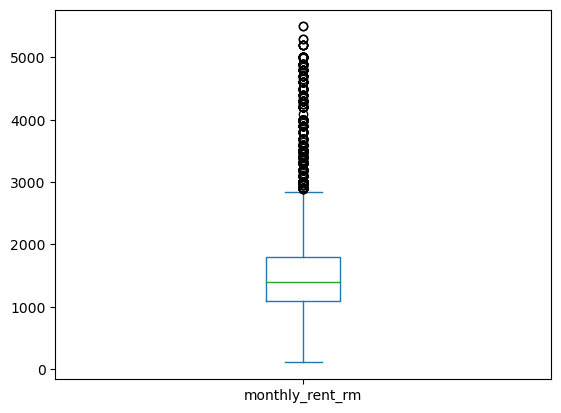

In [34]:
#| label: fig-rent-final
#| fig-cap: "Data after Outlier Removal"
dfx.to_pandas().monthly_rent_rm.plot(kind='box', x='monthly_rent_rm')

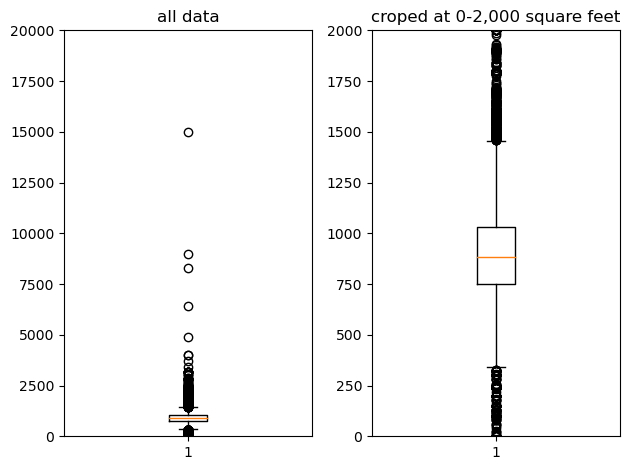

In [35]:
#| label: fig-size-comparison
#| fig-cap: "Raw Data Size sq.ft"
fig, axs = plt.subplots(1,2)
axs[0].boxplot(data=dfx.to_pandas(), x='size_sqft')
axs[0].set_ylim(0,20000)
axs[0].set_title('all data')

axs[1].boxplot(data=dfx.to_pandas(), x='size_sqft')
axs[1].set_ylim(0,2000)
axs[1].set_title('croped at 0-2,000 square feet')

plt.tight_layout()
plt.show()

In [36]:
#removing outliers below 500, and higher than 3000 sqft and below 50 sqft
dfx = dfx.filter((pl.col("size_sqft") > 50) & (pl.col("size_sqft") < 3000))

<Axes: >

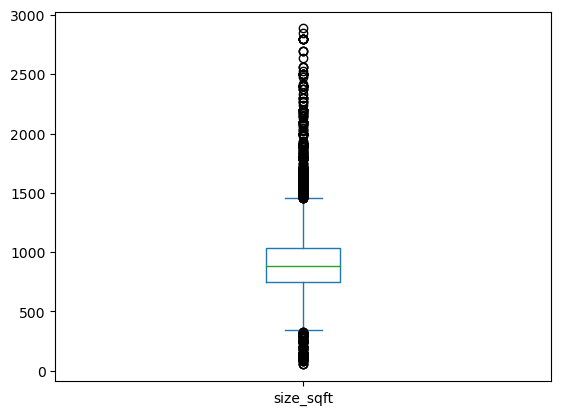

In [37]:
dfx.to_pandas()["size_sqft"].plot(kind='box')

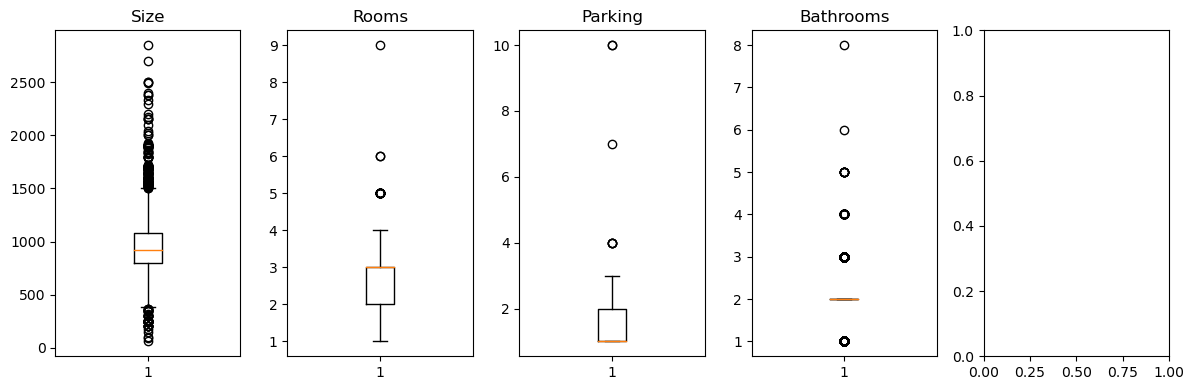

In [38]:
#| label: fig-complete-outliers
#| fig-cap: "Final Data after Outlier Removal"
fig, axs = plt.subplots(1,5, figsize=(12,4))
axs[0].boxplot(data=dfx.to_pandas().dropna(), x='size_sqft')
axs[1].boxplot(data=dfx.to_pandas().dropna(), x='rooms')
axs[2].boxplot(data=dfx.to_pandas().dropna(), x='parking')
axs[3].boxplot(data=dfx.to_pandas().dropna(), x='bathroom')
# axs[4].boxplot(data=dfx.dropna(), x='completion_year')

axs[0].set_title('Size')
axs[1].set_title('Rooms')
axs[2].set_title('Parking')
axs[3].set_title('Bathrooms')
# axs[4].set_title('Completion Year')

plt.tight_layout()
plt.show()

In [42]:
dfx.shape

(19761, 11)

#### Data Preprocessing
##### Input-Output

##### Train-Test Split Data

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(dfx.drop("monthly_rent_rm").to_pandas(),
                                                    dfx.select(pl.col("monthly_rent_rm")).to_numpy(),
                                                    test_size = 0.2,
                                                    random_state = 123)

In [41]:
len(X_test)/len(dfx.drop("monthly_rent_rm").to_pandas())

0.20004048378118516

In [42]:
X_train

,completion_year,location,property_type,rooms,parking,bathroom,size_sqft,furnished,region,nearby_railways
3850,2005.0,Wangsa Maju,Condominium,3.0,1.0,2.0,1152,Partially Furnished,Kuala Lumpur,True
16305,NaN,Cheras,Condominium,1.0,1.0,1.0,717,Partially Furnished,Kuala Lumpur,True
9873,1997.0,Mont Kiara,Condominium,2.0,NaN,2.0,1080,Fully Furnished,Kuala Lumpur,False
4734,2015.0,Cyberjaya,Apartment,1.0,1.0,8.0,550,Fully Furnished,Selangor,True
10718,1989.0,Cheras,Condominium,3.0,2.0,2.0,1200,Partially Furnished,Selangor,True
...,...,...,...,...,...,...,...,...,...,...
13435,2017.0,Seri Kembangan,Service Residence,2.0,NaN,2.0,966,Fully Furnished,Selangor,None
7763,NaN,Kajang,Flat,3.0,NaN,2.0,856,Not Furnished,Selangor,None
15377,2006.0,Sentul,Apartment,3.0,1.0,2.0,1100,Partially Furnished,Kuala Lumpur,True
17730,2015.0,Damansara Perdana,Condominium,1.0,NaN,2.0,850,Fully Furnished,Selangor,True


##### Preprocessing Original Data for Categorical Dtypes

One must paying attention to the number of categorical observation in the original data, with respect to the sampling train-test value. If, the test_size = 0.3, that means any categorical observation with a total of 3 and less, would not be distributed evenly among train and test data.

In [43]:
print(dfx["location"].n_unique())
print(X_train.location.nunique())
print(X_test.location.nunique())

127
125
114


In [44]:
print(dfx["property_type"].n_unique())
print(X_train.property_type.nunique())
print(X_test.property_type.nunique())

10
9
9


In [45]:
print(set(X_train.furnished.to_list()) - set(X_test.furnished.to_list()))
print(set(X_train.location.to_list()) - set(X_test.location.to_list()))
print(set(X_train.property_type.to_list()) - set(X_test.property_type.to_list()))
print(set(X_train.nearby_railways.to_list()) - set(X_test.nearby_railways.to_list()))

{None}
{'369', 'Serendah', 'Others', 'Salak Tinggi', 'Bandar Botanic', 'Kuala Selangor', 'Sungai Penchala', '43', 'Pulau Indah (Pulau Lumut)', 'Damansara Jaya', 'Mutiara Damansara', 'Hulu Langat', 'Chan Sow Lin'}
{'Houses'}
set()


#### 
Dropping Data

In [46]:
dfx["location"].value_counts().sort("counts").head(29)

location,counts
str,u32
"""Bandar Botanic…",1
"""Sungai Penchal…",1
"""43""",1
"""Chan Sow Lin""",1
"""369""",1
"""Telok Panglima…",1
"""Pulau Indah (P…",1
"""Damansara Jaya…",1
"""Puncak Jalil""",1


In [47]:
exclude_location = dfx["location"].value_counts().sort("counts").head(29)["location"].to_numpy()

In [48]:
exclude_location

array(['Damansara Jaya', 'Telok Panglima Garang', 'Puncak Jalil',
       'Chan Sow Lin', 'Sungai Penchala', '43', 'Bandar Botanic',
       'Pulau Indah (Pulau Lumut)', '369', 'Bukit Tunku',
       'Bukit Beruntung', 'Damansara', 'KL Eco City', 'Mutiara Damansara',
       'Kuala Selangor', 'Saujana Utama', 'Bukit Subang', 'Hulu Langat',
       '517', 'Serendah', 'Salak Tinggi', 'Bandar Bukit Tinggi', 'Others',
       'KL Sentral', 'Banting', 'Salak Selatan', 'Beranang', 'Jinjang',
       'Bandar Damai Perdana'], dtype=object)

In [49]:
dfx["property_type"].value_counts().sort("property_type")

property_type,counts
str,u32
"""Apartment""",5232
"""Condo / Servic…",1
"""Condominium""",8305
"""Duplex""",72
"""Flat""",577
"""Houses""",1
"""Others""",87
"""Service Reside…",5264
"""Studio""",189


In [50]:
dfx_new = dfx.filter((~pl.col("location").is_in(exclude_location.tolist())))
dfx_new = dfx_new.filter((~pl.col("property_type").is_in(["Condo / Services residence / Penthouse / Townhouse", "Townhouse Condo"])))

In [51]:
dfx_new["property_type"].value_counts()

property_type,counts
str,u32
"""Flat""",567
"""Condominium""",8282
"""Service Reside…",5246
"""Studio""",187
"""Duplex""",72
"""Apartment""",5196
"""Others""",86


In [52]:
dfx_new

completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,region,nearby_railways
f64,i64,str,str,i64,f64,f64,i64,str,str,bool
2021.0,2500,"""Kuchai Lama""","""Condominium""",3,2.0,2.0,1200,"""Fully Furnishe…","""Kuala Lumpur""",true
2021.0,1500,"""Cheras""","""Service Reside…",2,1.0,2.0,650,"""Partially Furn…","""Kuala Lumpur""",true
null,700,"""Puchong""","""Apartment""",3,1.0,2.0,700,"""Partially Furn…","""Selangor""",null
2017.0,1500,"""I-City""","""Service Reside…",2,null,1.0,600,"""Fully Furnishe…","""Selangor""",false
2015.0,1700,"""Pandan Jaya""","""Condominium""",3,1.0,2.0,1072,"""Partially Furn…","""Kuala Lumpur""",true
2018.0,1899,"""Taman Melawati…","""Condominium""",2,2.0,1.0,640,"""Fully Furnishe…","""Kuala Lumpur""",null
null,850,"""Damansara Dama…","""Apartment""",3,1.0,2.0,700,"""Partially Furn…","""Selangor""",true
2013.0,1200,"""Ampang""","""Apartment""",3,1.0,2.0,850,"""Not Furnished""","""Selangor""",null
2018.0,850,"""Shah Alam""","""Condominium""",1,1.0,1.0,250,"""Partially Furn…","""Selangor""",false


In [53]:
X_train, X_test, y_train, y_test = train_test_split(dfx_new.drop("monthly_rent_rm").to_pandas(),
                                                    dfx_new.select(pl.col("monthly_rent_rm")).to_numpy(),
                                                    test_size = 0.2,
                                                    random_state = 123)

In [54]:
print(set(X_train.furnished.to_list()) - set(X_test.furnished.to_list()))
print(set(X_train.location.to_list()) - set(X_test.location.to_list()))
print(set(X_train.property_type.to_list()) - set(X_test.property_type.to_list()))

{None}
set()
set()


In [55]:
print(dfx_new["location"].n_unique())
print(X_train.location.nunique())
print(X_test.location.nunique())

98
98
98


##### Training Data Imputation

In [56]:
X_train.isna().sum()

completion_year    7143
location              0
property_type         0
rooms                 2
parking            4461
bathroom              1
size_sqft             0
furnished             1
region                0
nearby_railways    4647
dtype: int64

In [57]:
X_train_num = X_train.select_dtypes(exclude='object')

In [58]:
X_train_num.isna().sum()

completion_year    7143
rooms                 2
parking            4461
bathroom              1
size_sqft             0
dtype: int64

##### 
We can fill completion year, rooms, parking and bathroom with mode

In [59]:
from sklearn.impute import SimpleImputer
def numericalImputation(X_train_num, strategy = 'most_frequent'):
    # create imputer
    imputer_num = SimpleImputer(missing_values = np.nan, strategy = strategy)
    
    # fitting
    imputer_num.fit(X_train_num)

    # transform
    imputed_data = imputer_num.transform(X_train_num)
    X_train_num_imputed = pd.DataFrame(imputed_data)

    # making imputated and non-imputated columns are the same
    X_train_num_imputed.columns = X_train_num.columns
    X_train_num_imputed.index = X_train_num.index

    return X_train_num_imputed, imputer_num

In [60]:
def numericalImputationNone(X_train_num, strategy = 'most_frequent'):
    # create imputer
    imputer_num = SimpleImputer(missing_values = None, strategy = strategy)
    
    # fitting
    imputer_num.fit(X_train_num)

    # transform
    imputed_data = imputer_num.transform(X_train_num)
    X_train_num_imputed = pd.DataFrame(imputed_data)

    # making imputated and non-imputated columns are the same
    X_train_num_imputed.columns = X_train_num.columns
    X_train_num_imputed.index = X_train_num.index

    return X_train_num_imputed, imputer_num

In [61]:
X_train_num, imputer_num = numericalImputation(X_train_num, strategy='most_frequent')
X_train_num.isna().sum()

completion_year    0
rooms              0
parking            0
bathroom           0
size_sqft          0
dtype: int64

##### Categorical Data

In [62]:
X_train_cat = X_train.select_dtypes(include='object')

In [63]:
X_train_cat

,location,property_type,furnished,region,nearby_railways
11478,Petaling Jaya,Condominium,Fully Furnished,Selangor,True
12682,Cheras,Apartment,Partially Furnished,Kuala Lumpur,True
3238,Sentul,Condominium,Fully Furnished,Kuala Lumpur,True
6272,Desa Pandan,Apartment,Partially Furnished,Kuala Lumpur,True
13753,Bukit Jalil,Apartment,Partially Furnished,Kuala Lumpur,True
...,...,...,...,...,...
13435,Setapak,Condominium,Partially Furnished,Kuala Lumpur,True
7763,Sentul,Condominium,Fully Furnished,Kuala Lumpur,True
15377,Bandar Sri Damansara,Apartment,Not Furnished,Selangor,False
17730,Bukit Jalil,Condominium,Fully Furnished,Kuala Lumpur,True


In [64]:
X_train_cat.isna().sum()

location              0
property_type         0
furnished             1
region                0
nearby_railways    4647
dtype: int64

#### 
Impute with mode

In [65]:
X_train_cat, imputer_num = numericalImputationNone(X_train_cat, strategy='most_frequent')
X_train_cat.isna().sum()

location           0
property_type      0
furnished          0
region             0
nearby_railways    0
dtype: int64

In [66]:
imputer_num

SimpleImputer(missing_values=None, strategy='most_frequent')

##### Preprocessing Categorical Variable

In [67]:
X_train_cat_ohe =  pd.get_dummies(X_train_cat)

In [68]:
X_train_cat_ohe

,location_360,location_389,location_639,location_Alam Impian,location_Ampang,location_Ampang Hilir,location_Ara Damansara,location_Balakong,location_Bandar Bukit Raja,location_Bandar Kinrara,...,property_type_Others,property_type_Service Residence,property_type_Studio,furnished_Fully Furnished,furnished_Not Furnished,furnished_Partially Furnished,region_Kuala Lumpur,region_Selangor,nearby_railways_False,nearby_railways_True
11478,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
12682,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
3238,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
6272,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
13753,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13435,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
7763,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
15377,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,True,False
17730,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True


In [69]:
ohe_columns = X_train_cat_ohe.columns

In [70]:
X_train_cat_ohe.isna().sum()

location_360                     0
location_389                     0
location_639                     0
location_Alam Impian             0
location_Ampang                  0
                                ..
furnished_Partially Furnished    0
region_Kuala Lumpur              0
region_Selangor                  0
nearby_railways_False            0
nearby_railways_True             0
Length: 112, dtype: int64

In [71]:
X_train_num.isna().sum()

completion_year    0
rooms              0
parking            0
bathroom           0
size_sqft          0
dtype: int64

##### Combine Numerical dan Categorical data

In [72]:
X_train_concat = pd.concat([X_train_num, X_train_cat_ohe], axis = 1)

In [73]:
X_train_concat

,completion_year,rooms,parking,bathroom,size_sqft,location_360,location_389,location_639,location_Alam Impian,location_Ampang,...,property_type_Others,property_type_Service Residence,property_type_Studio,furnished_Fully Furnished,furnished_Not Furnished,furnished_Partially Furnished,region_Kuala Lumpur,region_Selangor,nearby_railways_False,nearby_railways_True
11478,2021.0,1.0,2.0,1.0,466.0,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
12682,2021.0,2.0,1.0,1.0,650.0,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
3238,2017.0,2.0,1.0,2.0,900.0,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
6272,2021.0,3.0,1.0,2.0,900.0,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
13753,2021.0,3.0,1.0,2.0,850.0,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13435,2021.0,3.0,1.0,2.0,991.0,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
7763,2017.0,3.0,1.0,3.0,1200.0,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
15377,2021.0,3.0,1.0,2.0,750.0,False,False,False,False,False,...,False,False,False,False,True,False,False,True,True,False
17730,2020.0,3.0,2.0,3.0,1100.0,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True


In [74]:
X_train_concat.isnull().sum()

completion_year                  0
rooms                            0
parking                          0
bathroom                         0
size_sqft                        0
                                ..
furnished_Partially Furnished    0
region_Kuala Lumpur              0
region_Selangor                  0
nearby_railways_False            0
nearby_railways_True             0
Length: 117, dtype: int64

#### Standardization

In [75]:
from sklearn.preprocessing import StandardScaler
def standardizerData(data):
    data_columns = data.columns  #preserve columns
    data_index = data.index  #preserve index

    # create and fit standardizer
    standardizer = StandardScaler()
    standardizer.fit(data)

    # transform data
    standardized_data_raw = standardizer.transform(data)
    standardized_data = pd.DataFrame(standardized_data_raw)
    standardized_data.columns = data_columns
    standardized_data.index = data_index

    return standardized_data, standardizer

In [76]:
X_train_clean, standardizer = standardizerData(data = X_train_concat)

In [77]:
X_train_clean

,completion_year,rooms,parking,bathroom,size_sqft,location_360,location_389,location_639,location_Alam Impian,location_Ampang,...,property_type_Others,property_type_Service Residence,property_type_Studio,furnished_Fully Furnished,furnished_Not Furnished,furnished_Partially Furnished,region_Kuala Lumpur,region_Selangor,nearby_railways_False,nearby_railways_True
11478,0.575268,-2.097264,1.413963,-1.721298,-1.607282,-0.052392,-0.047928,-0.029867,-0.0348,-0.186684,...,-0.065449,-0.606478,-0.097527,1.169836,-0.460576,-0.821248,-0.996949,0.996949,-0.695389,0.695389
12682,0.575268,-0.841735,-0.575693,-1.721298,-0.932677,-0.052392,-0.047928,-0.029867,-0.0348,-0.186684,...,-0.065449,-0.606478,-0.097527,-0.854821,-0.460576,1.217659,1.003060,-1.003060,-0.695389,0.695389
3238,-0.107542,-0.841735,-0.575693,0.241117,-0.016094,-0.052392,-0.047928,-0.029867,-0.0348,-0.186684,...,-0.065449,-0.606478,-0.097527,1.169836,-0.460576,-0.821248,1.003060,-1.003060,-0.695389,0.695389
6272,0.575268,0.413794,-0.575693,0.241117,-0.016094,-0.052392,-0.047928,-0.029867,-0.0348,-0.186684,...,-0.065449,-0.606478,-0.097527,-0.854821,-0.460576,1.217659,1.003060,-1.003060,-0.695389,0.695389
13753,0.575268,0.413794,-0.575693,0.241117,-0.199410,-0.052392,-0.047928,-0.029867,-0.0348,-0.186684,...,-0.065449,-0.606478,-0.097527,-0.854821,-0.460576,1.217659,1.003060,-1.003060,-0.695389,0.695389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13435,0.575268,0.413794,-0.575693,0.241117,0.317543,-0.052392,-0.047928,-0.029867,-0.0348,-0.186684,...,-0.065449,-0.606478,-0.097527,-0.854821,-0.460576,1.217659,1.003060,-1.003060,-0.695389,0.695389
7763,-0.107542,0.413794,-0.575693,2.203531,1.083807,-0.052392,-0.047928,-0.029867,-0.0348,-0.186684,...,-0.065449,-0.606478,-0.097527,1.169836,-0.460576,-0.821248,1.003060,-1.003060,-0.695389,0.695389
15377,0.575268,0.413794,-0.575693,0.241117,-0.566044,-0.052392,-0.047928,-0.029867,-0.0348,-0.186684,...,-0.065449,-0.606478,-0.097527,-0.854821,2.171193,-0.821248,-0.996949,0.996949,1.438043,-1.438043
17730,0.404565,0.413794,1.413963,2.203531,0.717173,-0.052392,-0.047928,-0.029867,-0.0348,-0.186684,...,-0.065449,-0.606478,-0.097527,1.169836,-0.460576,-0.821248,1.003060,-1.003060,-0.695389,0.695389


##### Training Machine Learning
Since this is a regression model, R2 score and mean absolute error (MAE) will be used as a performance metrics.

The machine learning model will use baseline from average value of the target columns (monthly rent) and also result from linear regression model. After that, author used some of the recommended model based on previous works, which are random forest and gradient boosting to better improve the performance of the model.

##### Baseline-Average Value
The concept here is to use average value of the target as the easiest way to predict the monhtly rent of a unit.

In [78]:
y_baseline = np.ones(len(y_train)) * y_train.mean()
y_baseline

array([1566.81385281, 1566.81385281, 1566.81385281, ..., 1566.81385281,
       1566.81385281, 1566.81385281])

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Train the linear regression model
lin_reg = LinearRegression().fit(X_train_clean, y_train)

# Predict using the train data
y_pred_train = y_baseline

# Calculate R-squared
r2_baseline = r2_score(y_train, y_pred_train)

# Calculate MAE
mae_baseline = mean_absolute_error(y_train, y_pred_train)

print(f"R2-score: {r2_baseline:.4f} and MAE score: {mae_baseline:.4f}")

R2-score: 0.0000 and MAE score: 515.1917


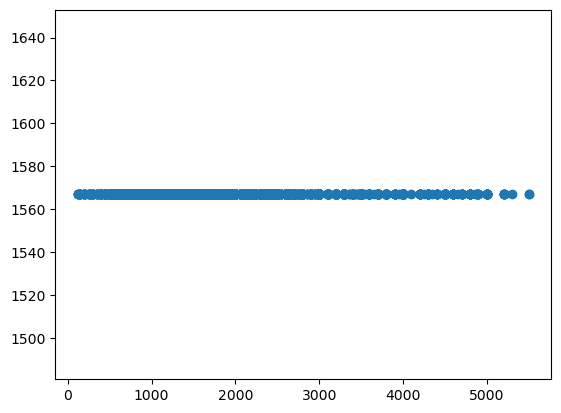

In [80]:
plt.scatter(x=y_train, y=y_pred_train);

##### Baseline-Linear Regression
The second method is using linear regression, which simply put is finding the minum total error (distance) between predicted value and the target value, using linear equation.

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train the linear regression model
lin_reg = LinearRegression().fit(X_train_clean, y_train)

# Predict using the train data
# y_pred = y_baseline
y_pred_train = lin_reg.predict(X_train_clean)

# Calculate mean absolute error
mae_linreg = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_linreg = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_linreg:.4f} and MAE score: {mae_linreg:.4f}")

R2-score: 0.6729 and MAE score: 283.0176


In [82]:
y_train.flatten()

array([1100,  900, 2200, ...,  700, 2200, 1350])

In [83]:
y_pred_train.shape

(15708, 1)

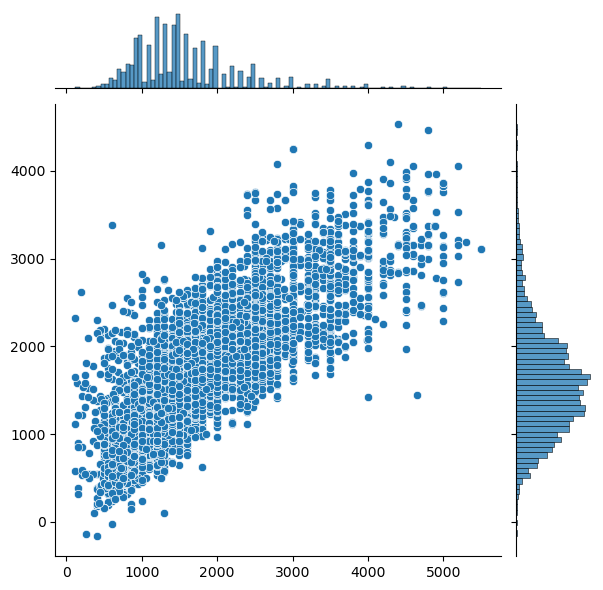

In [84]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten());

##### GradientBoosting
The gradient boosting, is one of the recommendation from previous works, is a model where each sample would be given a different weights (boosts) depending on its performance in predicting the value/ target.

In [85]:
from sklearn.ensemble import GradientBoostingRegressor
# Build random forest
grad_tree = GradientBoostingRegressor(random_state = 123)

In [86]:
# Fit random forest
grad_tree.fit(X_train_clean, y_train.flatten())

GradientBoostingRegressor(random_state=123)

In [87]:
# Predict
y_pred_train = grad_tree.predict(X_train_clean)
# y_pred_test = grad_tree.predict(X_test_clean)

# Calculate mean absolute error
mae_gb = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_gb = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_gb:.4f} and MAE score: {mae_gb:.4f}")

R2-score: 0.7065 and MAE score: 268.0626


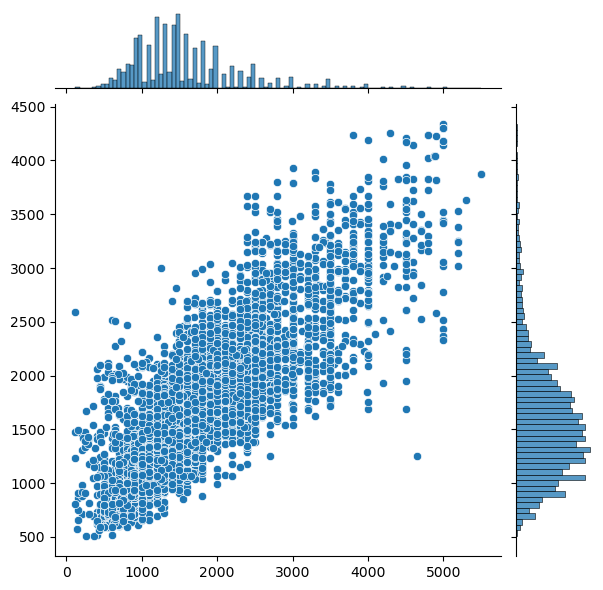

In [88]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten());

In [89]:
# GridSearch

from sklearn.model_selection import GridSearchCV 


params = {'n_estimators': [100, 200, 300, 400, 500],
              'learning_rate': [0.1, 0.05, 0.01]}

# Create gridsearch
grad_tree = GradientBoostingRegressor(random_state = 123)

grad_tree_cv = GridSearchCV(estimator = grad_tree,
                           param_grid = params,
                           cv = 5,
                           scoring = "neg_mean_absolute_error")

In [90]:
# Fit GridSearchCV
grad_tree_cv.fit(X_train_clean, y_train.flatten())

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=123),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_mean_absolute_error')

In [91]:
grad_tree_cv.best_params_

{'learning_rate': 0.1, 'n_estimators': 500}

In [92]:
# Refit the Adaboost
grad_tree = GradientBoostingRegressor(n_estimators = grad_tree_cv.best_params_["n_estimators"],
                                      random_state = 123)

grad_tree.fit(X_train_clean, y_train.flatten())

GradientBoostingRegressor(n_estimators=500, random_state=123)

In [93]:
# Predict
y_pred_train = grad_tree.predict(X_train_clean)

# Calculate mean absolute error
mae_gb_cv = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_gb_cv = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_gb_cv:.4f} and MAE score: {mae_gb_cv:.4f}")

R2-score: 0.7913 and MAE score: 225.1414


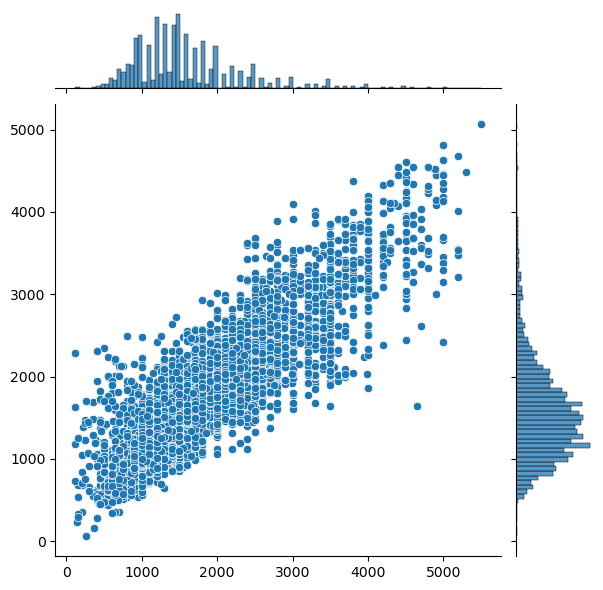

In [94]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten())

##### Random Forest
The last model, which was also recommended by previous works, is a model where not only it has weights based on its performance, but the feature selection in which the sample is measured was done at random. Therefore, reduces not only the variance, but also the bias.

In [95]:
from sklearn.ensemble import RandomForestRegressor

In [96]:
# Build random forest
rf_tree = RandomForestRegressor(n_estimators = 100,
                                criterion = "squared_error",
                                max_features = "sqrt",
                                random_state = 123)

In [97]:
# Fit random forest
rf_tree.fit(X_train_clean, y_train.flatten())

RandomForestRegressor(max_features='sqrt', random_state=123)

In [98]:
# Predict
y_pred_train = rf_tree.predict(X_train_clean)

# Calculate mean absolute error
mae_rf = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_rf = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_rf:.4f} and MAE score: {mae_rf:.4f}")

R2-score: 0.9602 and MAE score: 88.3644


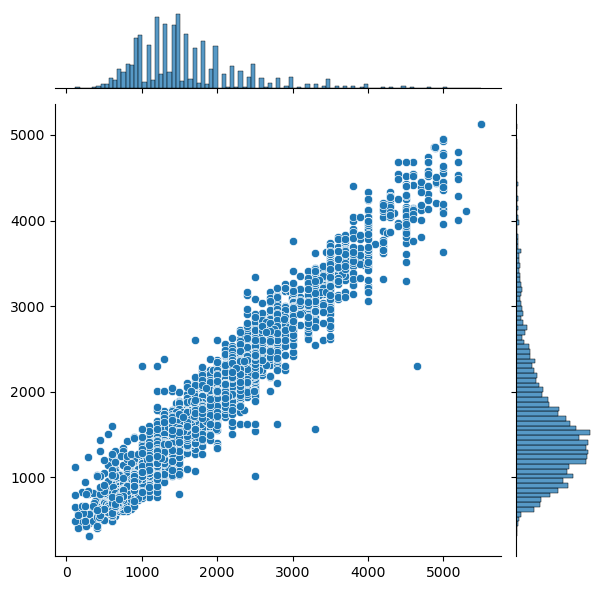

In [99]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten())

In [100]:
params = {"n_estimators": [100, 200, 300, 500 ],
          "max_features": ["sqrt", "log2"]}

# Create GridSearch
rf_tree = RandomForestRegressor(criterion = "squared_error",
                                random_state = 123)

rf_tree_cv = GridSearchCV(estimator = rf_tree,
                          param_grid = params,
                          cv = 5,
                          scoring = "neg_mean_absolute_error")

In [101]:
# Fit grid search cv
rf_tree_cv.fit(X_train_clean, y_train.flatten())

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 500]},
             scoring='neg_mean_absolute_error')

In [102]:
# Best params
rf_tree_cv.best_params_

{'max_features': 'sqrt', 'n_estimators': 500}

In [103]:
# Refit the Random Forest
rf_tree = RandomForestRegressor(criterion = "squared_error",
                                max_features = rf_tree_cv.best_params_["max_features"],
                                n_estimators = rf_tree_cv.best_params_["n_estimators"],
                                random_state = 123)

rf_tree.fit(X_train_clean, y_train.flatten())

RandomForestRegressor(max_features='sqrt', n_estimators=500, random_state=123)

In [104]:
# Predict
y_pred_train = rf_tree.predict(X_train_clean)

# Calculate mean absolute error
mae_rf_cv = mean_absolute_error(y_train, y_pred_train)

# # Calculate R-squared
r2_rf_cv = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_rf_cv:.4f} and MAE score: {mae_rf_cv:.4f}")

R2-score: 0.9615 and MAE score: 87.3736


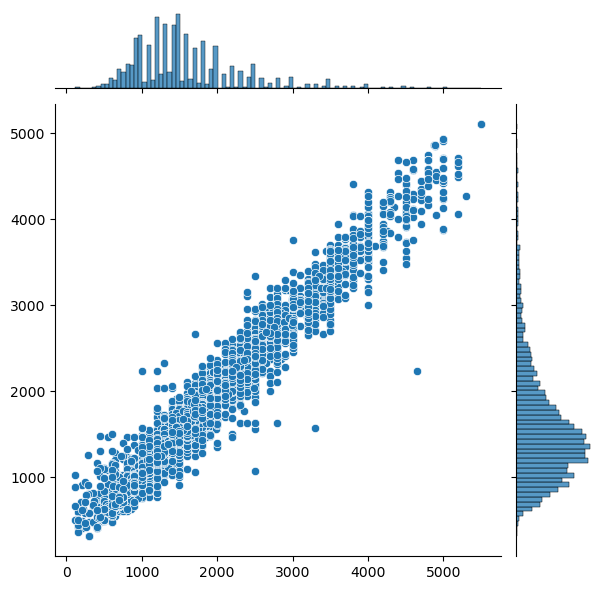

In [105]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten())

In [106]:
mae_score = [mae_baseline, mae_linreg, mae_gb, mae_gb_cv, mae_rf, mae_rf_cv]
r2_score = [r2_baseline, r2_linreg, r2_gb, r2_gb_cv, r2_rf, r2_rf_cv]
indexes = ["baseline", "linear regression", "gradient boosting", "gradient boosting with CV", "random forest",  "random forest with CV"]

summary_df = pd.DataFrame({
    "MAE Train": mae_score,
    "R2-Score": r2_score,
},index = indexes)

summary_df.sort_values(by='R2-Score', ascending=False)

,MAE Train,R2-Score
random forest with CV,87.373571,0.961521
random forest,88.364398,0.960210
gradient boosting with CV,225.141370,0.791306
gradient boosting,268.062553,0.706452
linear regression,283.017634,0.672893
baseline,515.191671,0.000000


#### 
From the above table, it can be seen that Random Forest model performs the best, and Gradient Boosting at the second place. This is similar to the previous work done by others, on house pricing.

##### Best Model

R2-score: 0.962 and MAE score: +/-87.37 RM


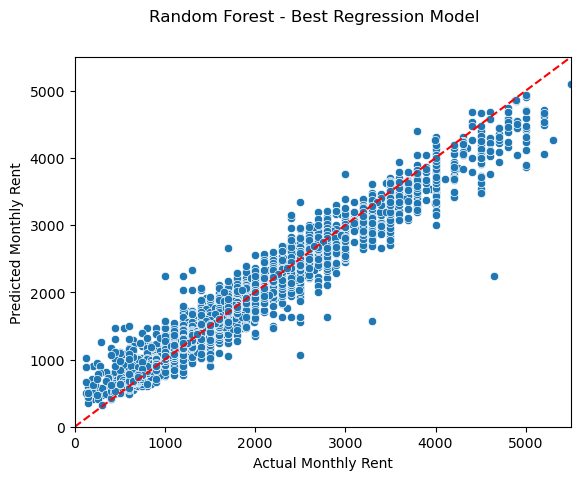

In [107]:
# Libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Setting up
rf_tree = RandomForestRegressor(n_estimators = 500,
                                criterion = "squared_error",
                                max_features = "sqrt",
                                random_state = 123)

# Fit model train
rf_tree.fit(X_train_clean, y_train.flatten())

# Predict model train
y_pred_train = rf_tree.predict(X_train_clean)

# Calculate mean absolute error
mae_rf_cv_train = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_rf_cv_train = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_rf_cv_train:.3f} and MAE score: +/-{mae_rf_cv_train:.2f} RM")

sns.scatterplot(x=y_train.flatten(), y=y_pred_train.flatten() )
plt.plot([0, 5500], [0,5500], "--r")
plt.xlim(0, 5500)
plt.xlabel("Actual Monthly Rent")
plt.ylim(0,5500)
plt.ylabel("Predicted Monthly Rent")
plt.suptitle("Random Forest - Best Regression Model")
plt.show()

### Data Prediction

##### Test Data Preprocessing
Simlar process done in train dataset need to be repeated on test dataset.

In [108]:
# Checking null data
X_test.isna().sum()

completion_year    1848
location              0
property_type         0
rooms                 1
parking            1135
bathroom              0
size_sqft             0
furnished             0
region                0
nearby_railways    1167
dtype: int64

In [109]:
X_test_num =  X_test.select_dtypes(exclude='object')
X_test_num

,completion_year,rooms,parking,bathroom,size_sqft
6522,2018.0,2.0,NaN,1.0,633
2183,NaN,2.0,1.0,2.0,980
12548,2017.0,2.0,1.0,2.0,856
18697,2005.0,3.0,1.0,2.0,1023
1395,1993.0,2.0,1.0,2.0,1250
...,...,...,...,...,...
2168,2021.0,3.0,2.0,2.0,850
8514,NaN,3.0,1.0,2.0,1060
10228,2010.0,3.0,1.0,2.0,765
7260,2019.0,1.0,1.0,1.0,450


In [110]:
X_test_num.isna().sum()

completion_year    1848
rooms                 1
parking            1135
bathroom              0
size_sqft             0
dtype: int64

In [111]:
X_test_num, imputer_num = numericalImputation(X_test_num, strategy='most_frequent')
X_test_num.isna().sum()

completion_year    0
rooms              0
parking            0
bathroom           0
size_sqft          0
dtype: int64

##### Categorical Data

In [112]:
X_test_cat = X_test.select_dtypes(include='object')
X_test_cat

,location,property_type,furnished,region,nearby_railways
6522,Taman Melawati,Service Residence,Fully Furnished,Kuala Lumpur,True
2183,Bukit Jalil,Condominium,Partially Furnished,Kuala Lumpur,None
12548,Desa Pandan,Service Residence,Fully Furnished,Kuala Lumpur,None
18697,Kota Damansara,Condominium,Fully Furnished,Selangor,True
1395,Taman Desa,Condominium,Fully Furnished,Kuala Lumpur,True
...,...,...,...,...,...
2168,Sentul,Condominium,Fully Furnished,Kuala Lumpur,True
8514,Pandan Jaya,Condominium,Not Furnished,Kuala Lumpur,True
10228,Cheras,Condominium,Fully Furnished,Kuala Lumpur,True
7260,Sepang,Condominium,Not Furnished,Selangor,False


In [113]:
X_test_cat.isna().sum()

location              0
property_type         0
furnished             0
region                0
nearby_railways    1167
dtype: int64

In [114]:
X_test_cat, imputer_num = numericalImputationNone(X_test_cat, strategy='most_frequent')
X_test_cat.isna().sum()

location           0
property_type      0
furnished          0
region             0
nearby_railways    0
dtype: int64

#### Categorical OHE

In [115]:
X_test_cat_ohe =  pd.get_dummies(X_test_cat)
X_test_cat_ohe.head(2)

,location_360,location_389,location_639,location_Alam Impian,location_Ampang,location_Ampang Hilir,location_Ara Damansara,location_Balakong,location_Bandar Bukit Raja,location_Bandar Kinrara,...,property_type_Others,property_type_Service Residence,property_type_Studio,furnished_Fully Furnished,furnished_Not Furnished,furnished_Partially Furnished,region_Kuala Lumpur,region_Selangor,nearby_railways_False,nearby_railways_True
6522,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,True
2183,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True


In [116]:
ohe_columns = X_test_cat_ohe.columns
ohe_columns

Index(['location_360', 'location_389', 'location_639', 'location_Alam Impian',
       'location_Ampang', 'location_Ampang Hilir', 'location_Ara Damansara',
       'location_Balakong', 'location_Bandar Bukit Raja',
       'location_Bandar Kinrara',
       ...
       'property_type_Others', 'property_type_Service Residence',
       'property_type_Studio', 'furnished_Fully Furnished',
       'furnished_Not Furnished', 'furnished_Partially Furnished',
       'region_Kuala Lumpur', 'region_Selangor', 'nearby_railways_False',
       'nearby_railways_True'],
      dtype='object', length=112)

In [117]:
X_test_concat = pd.concat([X_test_num,
                            X_test_cat_ohe],
                           axis = 1)

In [118]:
X_test_concat.head(2)

,completion_year,rooms,parking,bathroom,size_sqft,location_360,location_389,location_639,location_Alam Impian,location_Ampang,...,property_type_Others,property_type_Service Residence,property_type_Studio,furnished_Fully Furnished,furnished_Not Furnished,furnished_Partially Furnished,region_Kuala Lumpur,region_Selangor,nearby_railways_False,nearby_railways_True
6522,2018.0,2.0,1.0,1.0,633.0,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,True
2183,2021.0,2.0,1.0,2.0,980.0,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True


In [119]:
#sanity check
X_test_concat.isnull().sum()

completion_year                  0
rooms                            0
parking                          0
bathroom                         0
size_sqft                        0
                                ..
furnished_Partially Furnished    0
region_Kuala Lumpur              0
region_Selangor                  0
nearby_railways_False            0
nearby_railways_True             0
Length: 117, dtype: int64

##### Standardization

In [120]:
from sklearn.preprocessing import StandardScaler
def standardizerData(data):
    data_columns = data.columns  # agar nama kolom tidak hilang
    data_index = data.index  # agar index tidak hilang

    # create and fit standardizer
    standardizer = StandardScaler()
    standardizer.fit(data)

    # transform data
    standardized_data_raw = standardizer.transform(data)
    standardized_data = pd.DataFrame(standardized_data_raw)
    standardized_data.columns = data_columns
    standardized_data.index = data_index

    return standardized_data, standardizer

In [121]:
X_test_clean, standardizer = standardizerData(data = X_test_concat)

In [122]:
X_test_clean.head()

,completion_year,rooms,parking,bathroom,size_sqft,location_360,location_389,location_639,location_Alam Impian,location_Ampang,...,property_type_Others,property_type_Service Residence,property_type_Studio,furnished_Fully Furnished,furnished_Not Furnished,furnished_Partially Furnished,region_Kuala Lumpur,region_Selangor,nearby_railways_False,nearby_railways_True
6522,0.033208,-0.848088,-0.601528,-1.686467,-0.966041,-0.045175,-0.047922,-0.015958,-0.035701,-0.177518,...,-0.069718,1.686252,-0.100141,1.166438,-0.46446,-0.814679,1.011265,-1.011265,-0.704139,0.704139
2183,0.556363,-0.848088,-0.601528,0.249938,0.264148,-0.045175,-0.047922,-0.015958,-0.035701,-0.177518,...,-0.069718,-0.593031,-0.100141,-0.857311,-0.46446,1.227477,1.011265,-1.011265,-0.704139,0.704139
12548,-0.141177,-0.848088,-0.601528,0.249938,-0.175458,-0.045175,-0.047922,-0.015958,-0.035701,-0.177518,...,-0.069718,1.686252,-0.100141,1.166438,-0.46446,-0.814679,1.011265,-1.011265,-0.704139,0.704139
18697,-2.233797,0.416638,-0.601528,0.249938,0.416592,-0.045175,-0.047922,-0.015958,-0.035701,-0.177518,...,-0.069718,-0.593031,-0.100141,1.166438,-0.46446,-0.814679,-0.988860,0.988860,-0.704139,0.704139
1395,-4.326416,-0.848088,-0.601528,0.249938,1.221356,-0.045175,-0.047922,-0.015958,-0.035701,-0.177518,...,-0.069718,-0.593031,-0.100141,1.166438,-0.46446,-0.814679,1.011265,-1.011265,-0.704139,0.704139


##### Test Data Result

R2-score: 0.795 and MAE score: +/-199.40 RM


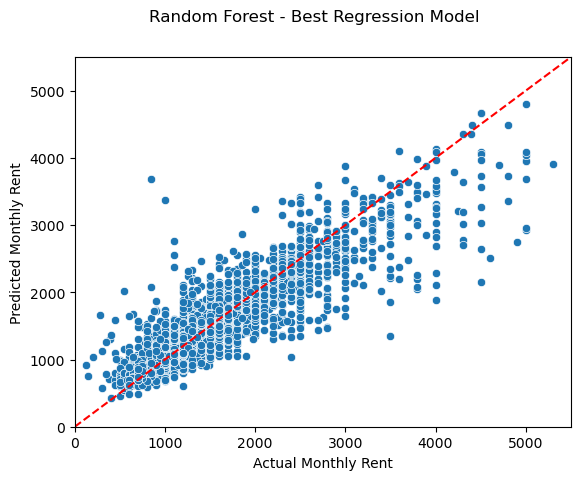

In [123]:
# libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


#setting up
rf_tree = RandomForestRegressor(n_estimators = 500,
                                criterion = "squared_error",
                                max_features = "sqrt",
                                random_state = 123)

#fit model train
rf_tree.fit(X_train_clean, y_train.flatten())

# Predict model
y_pred_test = rf_tree.predict(X_test_clean)

# Calculate mean absolute error
mae_rf_cv_test = mean_absolute_error(y_test, y_pred_test)

# # Calculate R-squared
r2_rf_cv_test = r2_score(y_test, y_pred_test)

print(f"R2-score: {r2_rf_cv_test:.3f} and MAE score: +/-{mae_rf_cv_test:.2f} RM")

sns.scatterplot(x=y_test.flatten(), y=y_pred_test.flatten())
plt.plot([0, 5500], [0,5500], "--r")
plt.xlim(0, 5500)
plt.xlabel("Actual Monthly Rent")
plt.ylim(0,5500)
plt.ylabel("Predicted Monthly Rent")
plt.suptitle("Random Forest - Best Regression Model")
plt.show()

In [124]:
mae_score = [mae_rf_cv_train, mae_rf_cv_test]
r2_score = [r2_rf_cv_train, r2_rf_cv_test]
indexes = ["train", "test"]

summary_df_train_test = pd.DataFrame({
    "MAE Train": mae_score,
    "R2-Score": r2_score,
},index = indexes)

summary_df_train_test

,MAE Train,R2-Score
train,87.373571,0.961521
test,199.403226,0.794956


##### Feature Importance

In [125]:
# calculate the feature importances
importances = rf_tree.feature_importances_

# rescale the importances back to the original scale of the features
importances = importances * X_train_clean.std()

# sort the feature importances in descending order
sorted_index = importances.argsort()[::-1]

# print the feature importances
dict_feature_importance = {}
for i in sorted_index:
    # print("{}: {}".format(X_train_clean.columns[i], importances[i]))
    dict_feature_importance.update({X_train_clean.columns[i]: importances[i]})
    
# Create a DataFrame from the dictionary
df = pd.DataFrame.from_dict(dict_feature_importance, orient='index', columns=['values'])

# Reset the index to become a column
df = df.reset_index()

# Rename the columns
df.columns = ['feature', 'importance_value']

df.sort_values(by='importance_value', ascending=False).head(10)

,feature,importance_value
0,size_sqft,0.204082
1,furnished_Fully Furnished,0.094557
2,completion_year,0.067160
3,bathroom,0.053913
4,rooms,0.048680
5,property_type_Apartment,0.048316
6,furnished_Not Furnished,0.043266
7,parking,0.034235
8,region_Selangor,0.032480
9,region_Kuala Lumpur,0.030297


##### Results
Result indicates that the best model for prediction is Random Forest with hyperparameter tuning, scoring 95% on R2-score, and a shy 100 RM on MAE. This proves to be a good model since the test dataset gives a scoring of 80% on R2, and 240 RM on MAE.

There are some factors that author believed to be affecting the result/ performance of the model:

Dropping missing value reduces the performance! Initial model uses half of the data (4-5k rows) and gives poorer performance on R2 and MAE. Imputation and keeping the number of rows close to the original dataset (9k rows) proves to be improving the model. Especially on test dataset.
Feature selection importance can be seen on the last table, but initially the selection was based on paper and intuition of the author (author lives and work in KL, Malaysia for 5 years). Feature such as completion_year and nearby_railways are important in improving the model.
Last but not least is the outlier identification. The best practice for me is using jointplot to see not only the distribution of the data in 2-dimension, but also in the third dimension (the density) of the data.
Some of the feature that were believed to be quite important even before doing the modeling is size, furnished and location. All three is available within the 10-most features affecting the modeling. As a context, location in KLCC is like Pondok Indah in South Jakarta. Location in Kiara is like BSD in South Tangerang.

#### Discussions
One of the feature that author thinks is significant but not appearing on the 10-best important feature is nearby_railways. This column is showing if a certain property has a close proximity to a railways (KTM/LRT). The issue is, half of the data is missing, hence the imputation. Author belives, the proximity to nearby railways line can be approximated using manhanttan distance of railways line to each property unit.